In [1]:
# %% imports
import scipy
import scipy.io
import scipy.stats

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

try: # see if tqdm is available, otherwise define it as a dummy
    try: # Ipython seem to require different tqdm.. try..except seem to be the easiest way to check
        __IPYTHON__
        from tqdm.notebook import tqdm
    except:
        from tqdm import tqdm
except Exception as e:
    print(e)
    print(
        "install tqdm (conda install tqdm, or pip install tqdm) to get nice progress bars. "
    )

    def tqdm(iterable, *args, **kwargs):
        return iterable

from eskf import (
    ESKF,
    POS_IDX,
    VEL_IDX,
    ATT_IDX,
    ACC_BIAS_IDX,
    GYRO_BIAS_IDX,
    ERR_ATT_IDX,
    ERR_ACC_BIAS_IDX,
    ERR_GYRO_BIAS_IDX,
)

from quaternion import quaternion_to_euler
from cat_slice import CatSlice

# %% plot config check and style setup


# to see your plot config
print(f"matplotlib backend: {matplotlib.get_backend()}")
print(f"matplotlib config file: {matplotlib.matplotlib_fname()}")
print(f"matplotlib config dir: {matplotlib.get_configdir()}")
plt.close("all")

try:
    plt_styles = ["science", "grid", "bright", "no-latex"]
    plt.style.use(plt_styles)
    print(f"pyplot using style set {plt_styles}")
except Exception as e:
    print(e)
    print("setting grid and only grid and legend manually")
    plt.rcParams.update(
        {
            # setgrid
            "axes.grid": True,
            "grid.linestyle": ":",
            "grid.color": "k",
            "grid.alpha": 0.5,
            "grid.linewidth": 0.5,
            # Legend
            "legend.frameon": True,
            "legend.framealpha": 1.0,
            "legend.fancybox": True,
            "legend.numpoints": 1,
        }
    )
    
# %% load data and plot
filename_to_load = "task_simulation.mat"
loaded_data = scipy.io.loadmat(filename_to_load)

S_a            = loaded_data["S_a"]
S_g            = loaded_data["S_g"]
lever_arm      = loaded_data["leverarm"].ravel()
timeGNSS       = loaded_data["timeGNSS"].ravel()
timeIMU        = loaded_data["timeIMU"].ravel()
x_true         = loaded_data["xtrue"].T
z_acceleration = loaded_data["zAcc"].T
z_GNSS         = loaded_data["zGNSS"].T
z_gyroscope    = loaded_data["zGyro"].T


dt         = np.mean(np.diff(timeIMU))
steps      = len(z_acceleration)
gnss_steps = len(z_GNSS)

matplotlib backend: module://ipykernel.pylab.backend_inline
matplotlib config file: /home/jakobeg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc
matplotlib config dir: /home/jakobeg/.config/matplotlib
pyplot using style set ['science', 'grid', 'bright', 'no-latex']


In [2]:
import utils
import quaternion as q
import eskf

q1 = np.array([0, 2, 3, 1]).reshape(4,)
q1 = q.quaternion_normalize(q1)
print(q1, "\n", q.quaternion_to_euler(q1))

[0.         0.53452248 0.80178373 0.26726124] 
 [ 2.67794504 -0.2897517   2.03444394]


In [3]:
# %% Measurement noise
# IMU noise values for STIM300, based on datasheet and simulation sample rate
# Continous noise
# TODO: What to remove here?
cont_gyro_noise_std = 4.36e-5  # (rad/s)/sqrt(Hz)
cont_acc_noise_std  = 1.167e-3  # (m/s**2)/sqrt(Hz)

# Discrete sample noise at simulation rate used
rate_std = 0.5 * cont_gyro_noise_std * np.sqrt(1 / dt)
acc_std  = 0.5 * cont_acc_noise_std  * np.sqrt(1 / dt)

# Bias values
rate_bias_driving_noise_std = 5e-5
cont_rate_bias_driving_noise_std = (1/3)*rate_bias_driving_noise_std / np.sqrt(1/dt)

acc_bias_driving_noise_std  = 4e-3
cont_acc_bias_driving_noise_std  = 6 * acc_bias_driving_noise_std / np.sqrt(1/dt)

# Position and velocity measurement
p_std  = np.array([0.3, 0.3, 0.5])  # Measurement noise
R_GNSS = np.diag(p_std ** 2)

p_acc  = 1e-16
p_gyro = 1e-16

# %% Estimator
eskf = ESKF(
    acc_std,
    rate_std,
    cont_acc_bias_driving_noise_std,
    cont_rate_bias_driving_noise_std,
    p_acc,
    p_gyro,
    S_a=S_a, # set the accelerometer correction matrix
    S_g=S_g, # set the gyro correction matrix,
    debug=True # : False to avoid expensive debug checks, can also be suppressed by calling 'python -O run_INS_simulated.py'
)

# %% Allocate
x_est   = np.zeros((steps, 16))
P_est   = np.zeros((steps, 15, 15))

x_pred  = np.zeros((steps, 16))
P_pred  = np.zeros((steps, 15, 15))

delta_x = np.zeros((steps, 15))

NIS     = np.zeros(gnss_steps)

NEES_all      = np.zeros(steps)
NEES_pos      = np.zeros(steps)
NEES_vel      = np.zeros(steps)
NEES_att      = np.zeros(steps)
NEES_accbias  = np.zeros(steps)
NEES_gyrobias = np.zeros(steps)

# %% Initialise
x_pred[0, POS_IDX] = np.array([0, 0, -5])  # starting 5 metres above ground
x_pred[0, VEL_IDX] = np.array([20, 0, 0])  # starting at 20 m/s due north
x_pred[0, 6]       = 1  # no initial rotation: nose to North, right to East, and belly down

#Initialize covariances
P_pred[0][POS_IDX **2]           =  10**2 * np.eye(3)
P_pred[0][VEL_IDX **2]           =  20**2 * np.eye(3)
P_pred[0][ERR_ATT_IDX **2]       = (10*np.pi/180)**2 * np.eye(3) 
P_pred[0][ERR_ACC_BIAS_IDX **2]  =  0.05**2 * np.eye(3)
P_pred[0][ERR_GYRO_BIAS_IDX **2] =  0.05**2 * np.eye(3)


ESKF in debug mode, some numeric properties are checked at the expense of calculation speed


In [4]:
# %% Run estimation

N: int       = 9000  #: choose a small value to begin with (500?), and gradually increase as you OK results
doGNSS: bool = True  #: Set this to False if you want to check that the predictions make sense over reasonable time lenghts

NEES_all      = np.zeros(N)
NEES_pos      = np.zeros(N)
NEES_vel      = np.zeros(N)
NEES_att      = np.zeros(N)
NEES_accbias  = np.zeros(N)
NEES_gyrobias = np.zeros(N)

GNSSk: int = 0  # keep track of current step in GNSS measurements
for k in tqdm(range(N)):
    if doGNSS and timeIMU[k] >= timeGNSS[GNSSk]:
        
        NIS[GNSSk]         = eskf.NIS_GNSS_position(x_pred[k], P_pred[k], z_GNSS[GNSSk], R_GNSS, lever_arm)
        x_est[k], P_est[k] = eskf.update_GNSS_position(x_pred[k], P_pred[k], z_GNSS[GNSSk], R_GNSS, lever_arm)
        assert np.all(np.isfinite(P_est[k])), f"Not finite P_pred at index {k}"

        GNSSk += 1
    else:
        # no updates, so let us take estimate = prediction
        x_est[k] = x_pred[k]
        P_est[k] = P_pred[k]

    delta_x[k] = eskf.delta_x(x_est[k], x_true[k])
    #"""
    (
        NEES_all[k],
        NEES_pos[k],
        NEES_vel[k],
        NEES_att[k],
        NEES_accbias[k],
        NEES_gyrobias[k],
    ) = eskf.NEESes(x_est[k], P_est[k], x_true[k])#: The true error state at step k
    #"""
    
    if k < N - 1:
        x_pred[k+1], P_pred[k+1] = eskf.predict(x_est[k], P_est[k], z_acceleration[k+1], z_gyroscope[k+1], dt)
        #: measurements come from the the present and past, not the future

    if eskf.debug:
        assert np.all(np.isfinite(P_pred[k])), f"Not finite P_pred at index {k + 1}"
print("N: ", N, "   GNSSk: ", GNSSk)


N:  9000    GNSSk:  90


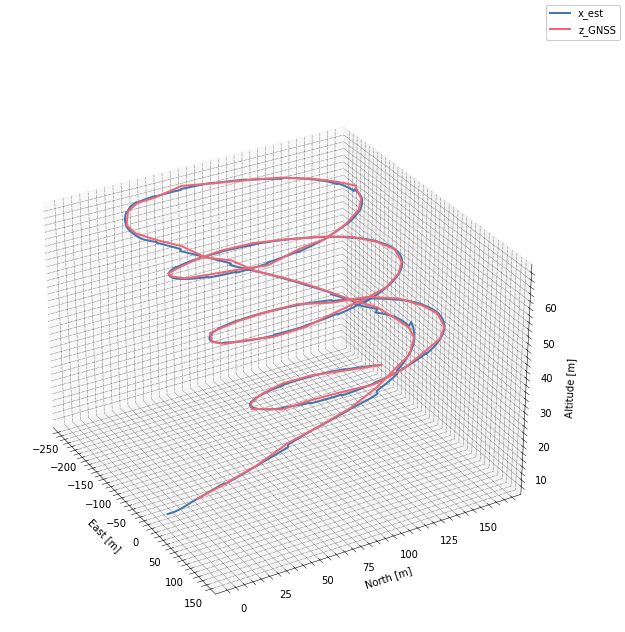

In [20]:
# %% Plots
fig1 = plt.figure(1, figsize=(10,10))
ax = plt.axes(projection="3d")

ax.plot3D(x_est[:N, 1], x_est[:N, 0], -x_est[:N, 2], linewidth=2, label="x_est")
ax.plot3D(z_GNSS[:GNSSk, 1], z_GNSS[:GNSSk, 0], -z_GNSS[:GNSSk, 2], linewidth=2, label="z_GNSS")
#ax.plot3D(x_true[:N, 1], x_true[:N, 0], -x_true[:N, 2], linewidth=1, label="x_true")
ax.set_xlabel("East [m]")
ax.set_ylabel("North [m]")
ax.set_zlabel("Altitude [m]")
fig1.legend()
ax.view_init(30, -30)

Text(0.5, 0.98, 'States estimates')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


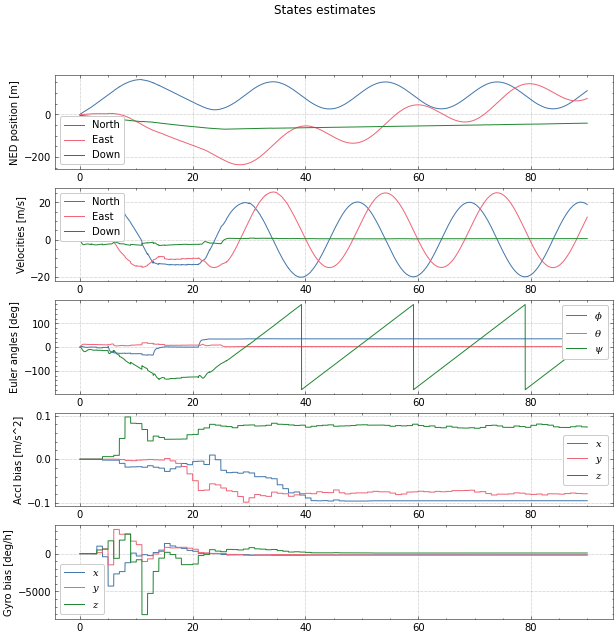

In [6]:
# state estimation
t = np.linspace(0, dt * (N - 1), N)
eul = np.apply_along_axis(quaternion_to_euler, 1, x_est[:N, ATT_IDX])
eul_true = np.apply_along_axis(quaternion_to_euler, 1, x_true[:N, ATT_IDX])

fig2, axs2 = plt.subplots(5, 1, num=2, figsize = (10,10), clear=True)

axs2[0].plot(t, x_est[:N, POS_IDX])
axs2[0].set(ylabel="NED position [m]")
axs2[0].legend(["North", "East", "Down"])


axs2[1].plot(t, x_est[:N, VEL_IDX])
axs2[1].set(ylabel="Velocities [m/s]")
axs2[1].legend(["North", "East", "Down"])


axs2[2].plot(t, eul[:N] * 180 / np.pi)
axs2[2].set(ylabel="Euler angles [deg]")
axs2[2].legend([r"$\phi$", r"$\theta$", r"$\psi$"])


axs2[3].plot(t, x_est[:N, ACC_BIAS_IDX])
axs2[3].set(ylabel="Accl bias [m/s^2]")
axs2[3].legend(["$x$", "$y$", "$z$"])


axs2[4].plot(t, x_est[:N, GYRO_BIAS_IDX] * 180 / np.pi * 3600)
axs2[4].set(ylabel="Gyro bias [deg/h]")
axs2[4].legend(["$x$", "$y$", "$z$"])


fig2.suptitle("States estimates")

Text(0.5, 0.98, 'States estimate errors')

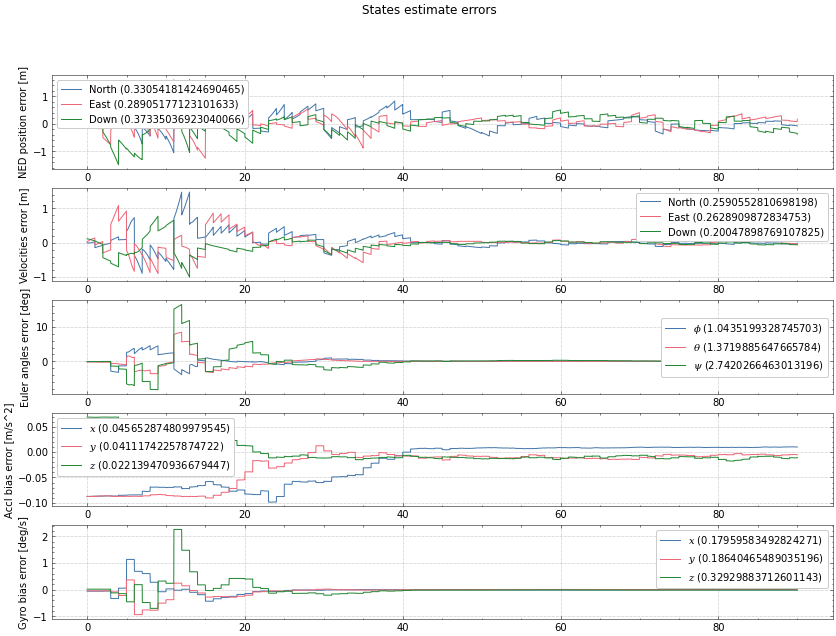

In [16]:
# state error plots
fig3, axs3 = plt.subplots(5, 1, num=3, figsize = (14,10), clear=True)
delta_x_RMSE = np.sqrt(np.mean(delta_x[:N] ** 2, axis=0))  # TODO use this in legends
axs3[0].plot(t, delta_x[:N, POS_IDX])
axs3[0].set(ylabel="NED position error [m]")
axs3[0].legend(
    [
        f"North ({np.sqrt(np.mean(delta_x[:N, 0]**2))})",
        f"East ({np.sqrt(np.mean(delta_x[:N, 1]**2))})",
        f"Down ({np.sqrt(np.mean(delta_x[:N, 2]**2))})",
    ]
)

axs3[1].plot(t, delta_x[:N, VEL_IDX])
axs3[1].set(ylabel="Velocities error [m]")
axs3[1].legend(
    [
        f"North ({np.sqrt(np.mean(delta_x[:N, 3]**2))})",
        f"East ({np.sqrt(np.mean(delta_x[:N, 4]**2))})",
        f"Down ({np.sqrt(np.mean(delta_x[:N, 5]**2))})",
    ]
)

# quick wrap func
wrap_to_pi = lambda rads: (rads + np.pi) % (2 * np.pi) - np.pi
eul_error = wrap_to_pi(eul[:N] - eul_true[:N]) * 180 / np.pi
axs3[2].plot(t, eul_error)
axs3[2].set(ylabel="Euler angles error [deg]")
axs3[2].legend(
    [
        rf"$\phi$ ({np.sqrt(np.mean((eul_error[:N, 0] )**2))})",
        rf"$\theta$ ({np.sqrt(np.mean((eul_error[:N, 1] )**2))})",
        rf"$\psi$ ({np.sqrt(np.mean((eul_error[:N, 2] )**2))})",
    ], loc=5
)

axs3[3].plot(t, delta_x[:N, ERR_ACC_BIAS_IDX])
axs3[3].set(ylabel="Accl bias error [m/s^2]")
axs3[3].legend(
    [
        f"$x$ ({np.sqrt(np.mean(delta_x[:N, 9]**2))})",
        f"$y$ ({np.sqrt(np.mean(delta_x[:N, 10]**2))})",
        f"$z$ ({np.sqrt(np.mean(delta_x[:N, 11]**2))})",
    ]
)

axs3[4].plot(t, delta_x[:N, ERR_GYRO_BIAS_IDX] * 180 / np.pi)
axs3[4].set(ylabel="Gyro bias error [deg/s]")
axs3[4].legend(
    [
        f"$x$ ({np.sqrt(np.mean((delta_x[:N, 12]* 180 / np.pi)**2))})",
        f"$y$ ({np.sqrt(np.mean((delta_x[:N, 13]* 180 / np.pi)**2))})",
        f"$z$ ({np.sqrt(np.mean((delta_x[:N, 14]* 180 / np.pi)**2))})",
    ]
)

fig3.suptitle("States estimate errors")

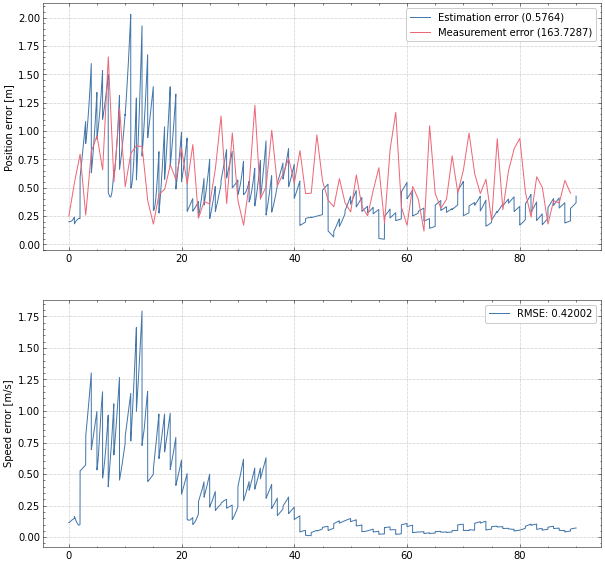

In [8]:
# Error distance plot
fig4, axs4 = plt.subplots(2, 1, num=4, figsize=(10,10), clear=True)

axs4[0].plot(t, np.linalg.norm(delta_x[:N, POS_IDX], axis=1))
axs4[0].plot(
    np.arange(0, N, 100) * dt,
    np.linalg.norm(x_true[99:N:100, :3] - z_GNSS[:GNSSk], axis=1),
)
axs4[0].set(ylabel="Position error [m]")
axs4[0].legend(
    [
        f"Estimation error ({round(np.sqrt(np.mean(np.sum(delta_x[:N, POS_IDX]**2, axis=1))),4)})",
        f"Measurement error ({round(np.sqrt(np.mean(np.sum((x_true[99:N:100, POS_IDX] - z_GNSS[GNSSk - 1])**2, axis=1))),4)})",
    ]
)

axs4[1].plot(t, np.linalg.norm(delta_x[:N, VEL_IDX], axis=1))
axs4[1].set(ylabel="Speed error [m/s]")
axs4[1].legend([f"RMSE: {round(np.sqrt(np.mean(np.sum(delta_x[:N, VEL_IDX]**2, axis=1))),5)}"])



(0.0, 20.0)

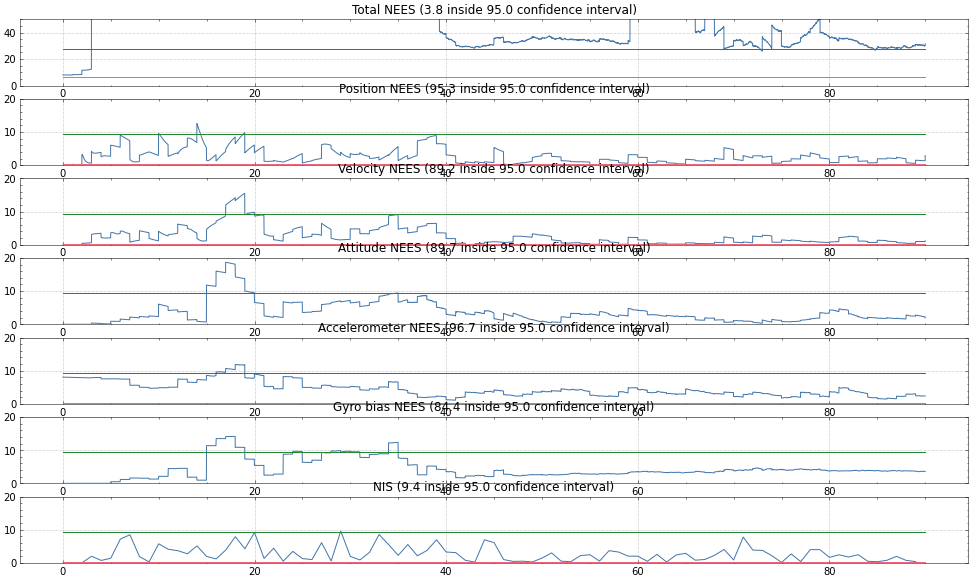

In [9]:
# %% Consistency
confprob = 0.95
CI15 = np.array(scipy.stats.chi2.interval(confprob, 15)).reshape((2, 1))
CI3 = np.array(scipy.stats.chi2.interval(confprob, 3)).reshape((2, 1))

fig5, axs5 = plt.subplots(7, 1, num=5, figsize=(17,10), clear=True)

axs5[0].plot(t, (NEES_all[:N]).T)
axs5[0].plot(np.array([0, N - 1]) * dt, (CI15 @ np.ones((1, 2))).T)
insideCI = np.mean((CI15[0] <= NEES_all) * (NEES_all <= CI15[1]))
axs5[0].set(
    title=f"Total NEES ({100 *  insideCI:.1f} inside {100 * confprob} confidence interval)"
)
axs5[0].set_ylim([0, 50])

axs5[1].plot(t, (NEES_pos[0:N]).T)
axs5[1].plot(np.array([0, N - 1]) * dt, (CI3 @ np.ones((1, 2))).T)
insideCI = np.mean((CI3[0] <= NEES_pos) * (NEES_pos <= CI3[1]))
axs5[1].set(
    title=f"Position NEES ({100 *  insideCI:.1f} inside {100 * confprob} confidence interval)"
)
axs5[1].set_ylim([0, 20])

axs5[2].plot(t, (NEES_vel[0:N]).T)
axs5[2].plot(np.array([0, N - 1]) * dt, (CI3 @ np.ones((1, 2))).T)
insideCI = np.mean((CI3[0] <= NEES_vel) * (NEES_vel <= CI3[1]))
axs5[2].set(
    title=f"Velocity NEES ({100 *  insideCI:.1f} inside {100 * confprob} confidence interval)"
)
axs5[2].set_ylim([0, 20])

axs5[3].plot(t, (NEES_att[0:N]).T)
axs5[3].plot(np.array([0, N - 1]) * dt, (CI3 @ np.ones((1, 2))).T)
insideCI = np.mean((CI3[0] <= NEES_att) * (NEES_att <= CI3[1]))
axs5[3].set(
    title=f"Attitude NEES ({100 *  insideCI:.1f} inside {100 * confprob} confidence interval)"
)
axs5[3].set_ylim([0, 20])

axs5[4].plot(t, (NEES_accbias[0:N]).T)
axs5[4].plot(np.array([0, N - 1]) * dt, (CI3 @ np.ones((1, 2))).T)
insideCI = np.mean((CI3[0] <= NEES_accbias) * (NEES_accbias <= CI3[1]))
axs5[4].set(
    title=f"Accelerometer NEES ({100 *  insideCI:.1f} inside {100 * confprob} confidence interval)"
)
axs5[4].set_ylim([0, 20])

axs5[5].plot(t, (NEES_gyrobias[0:N]).T)
axs5[5].plot(np.array([0, N - 1]) * dt, (CI3 @ np.ones((1, 2))).T)
insideCI = np.mean((CI3[0] <= NEES_gyrobias) * (NEES_gyrobias <= CI3[1]))
axs5[5].set(
    title=f"Gyro bias NEES ({100 *  insideCI:.1f} inside {100 * confprob} confidence interval)"
)
axs5[5].set_ylim([0, 20])

axs5[6].plot(NIS[:GNSSk])
axs5[6].plot(np.array([0, N - 1]) * dt, (CI3 @ np.ones((1, 2))).T)
insideCI = np.mean((CI3[0] <= NIS) * (NIS <= CI3[1]))
axs5[6].set(
    title=f"NIS ({100 *  insideCI:.1f} inside {100 * confprob} confidence interval)"
)
axs5[6].set_ylim([0, 20])


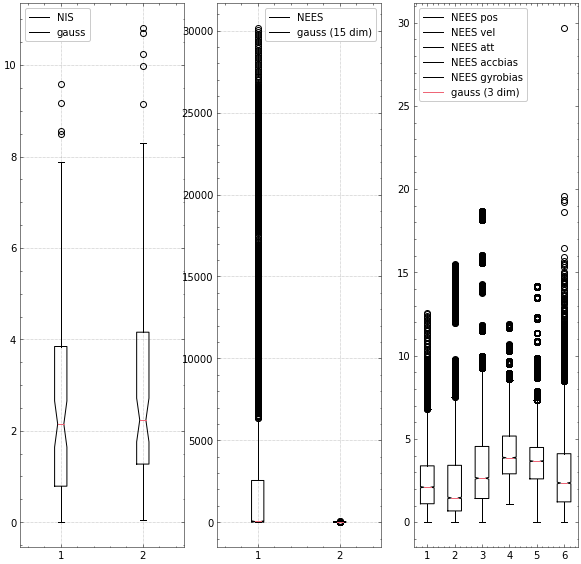

In [10]:
# boxplot
fig6, axs6 = plt.subplots(1, 3, figsize=(10,10))

gauss_compare = np.sum(np.random.randn(3, GNSSk)**2, axis=0)
axs6[0].boxplot([NIS[0:GNSSk], gauss_compare], notch=True)
axs6[0].legend(['NIS', 'gauss'])
plt.grid()

gauss_compare_15 = np.sum(np.random.randn(15, N)**2, axis=0)
axs6[1].boxplot([NEES_all[0:N].T, gauss_compare_15], notch=True)
axs6[1].legend(['NEES', 'gauss (15 dim)'])
plt.grid()

gauss_compare_3  = np.sum(np.random.randn(3, N)**2, axis=0)
axs6[2].boxplot([NEES_pos[0:N].T, NEES_vel[0:N].T, NEES_att[0:N].T, NEES_accbias[0:N].T, NEES_gyrobias[0:N].T, gauss_compare_3], notch=True)
axs6[2].legend(['NEES pos', 'NEES vel', 'NEES att', 'NEES accbias', 'NEES gyrobias', 'gauss (3 dim)'])
plt.grid()
